<a href="https://colab.research.google.com/github/Figgueh/FreshPrints/blob/main/FreshPrints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download dataset

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexanderfigueiras","key":"e92ab0181edbb41ad63694b4c3253a3f"}'}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [6]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [7]:
!kaggle datasets download -d ruizgara/socofing

100% 836M/838M [00:28<00:00, 38.9MB/s]
100% 838M/838M [00:28<00:00, 31.0MB/s]


In [8]:
!mkdir Dataset
!cp /content/socofing.zip /content/Dataset/socofing.zip
!unzip -q /content/Dataset/socofing.zip -d /content/Dataset
!rm /content/Dataset/socofing.zip

In [9]:
import os
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [10]:
img_size = 96

def load_data(path, train=True):
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1 # to_categorical encodes starting from 0
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _  = etc.split('_')
        if lr=='Left':
            base = 0 # left hand corresponding to 0-4
        else: base  = 5 # right hand corresponding to 5-9
        if finger=="little":
            fingerNum = base + 0
        elif finger=='ring':
            fingerNum = base + 1
        elif finger=='middle':
            fingerNum = base + 2
        elif finger=='index':
            fingerNum = base + 3 
        else: fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize])
    return data

This is the origional section of code with some modifications to the way 'Altered_data' is constructed. 

If we attempt to load this many images we won't have enough memory to even begin training our model.

In [11]:
# Altered_path = "/content/Dataset/SOCOFing/Altered/Altered-"
# Real_path = "/content/Dataset/SOCOFing/Real"
Altered_path = "/content/Dataset/SOCOFing/Altered/Altered-"
Real_path = "/content/Dataset/SOCOFing/Real"


# Easy_data = load_data(Altered_path+'Easy', train=True)
Medium_data = load_data(Altered_path+'Medium', train=True)
Hard_data = load_data(Altered_path+'Hard', train=True)
Real_data = load_data(Real_path, train=False)

Altered_data = np.concatenate([np.array(Medium_data, dtype=object), np.array(Hard_data, dtype=object)], dtype=object, axis=0)

# del Easy_data
del Medium_data, Hard_data # Free some memory

Loading data from:  /content/Dataset/SOCOFing/Altered/Altered-Medium
Loading data from:  /content/Dataset/SOCOFing/Altered/Altered-Hard
Loading data from:  /content/Dataset/SOCOFing/Real


In [14]:
X_Altered, y_SubjectID_Altered, y_fingerNum_Altered = [], [], []

for SubjectID, fingerNum, feature in Altered_data:
    X_Altered.append(feature)
    y_SubjectID_Altered.append(SubjectID)
    y_fingerNum_Altered.append(fingerNum)

X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 1)
X_Altered = X_Altered / 255.0 # Normalize to [0, 1]
y_SubjectID_Altered = to_categorical(y_SubjectID_Altered, num_classes=600) # 600 persons in total
y_fingerNum_Altered = to_categorical(y_fingerNum_Altered, num_classes=10) # 10 fingers per person

X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val = train_test_split(
    X_Altered, y_SubjectID_Altered, test_size=0.2, random_state=2)
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)


del Altered_data, y_SubjectID_Altered # Free some memory again

In [15]:
X_test, y_SubjectID_test, y_fingerNum_test = [], [], []

for SubjectID, fingerNum, feature in Real_data:
    X_test.append(feature)
    y_SubjectID_test.append(SubjectID)
    y_fingerNum_test.append(fingerNum)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=600)
y_fingerNum_test = to_categorical(y_fingerNum_test, num_classes=10)

del Real_data;

In [ ]:
# This is the origional method:


nets = 2
model = [0] * nets
final_Dense_units = [600, 10]
model_name = ['SubjectID_Mod', 'FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.5))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "SubjectID_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 42, 42, 64)       256       
 hNormalization)                                                 
                                                     

In [ ]:
# RUNNING BEST:
# Id recognition accuracy:  99.19999837875366 %
# Finger recognition accuracy:  91.33333563804626 %

nets = 2
model = [0] * nets
final_Dense_units = [600, 10]
model_name = ['SubjectID_Mod', 'FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (7, 7), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "SubjectID_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 90, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 41, 41, 64)       256       
 hNormalization)                                                 
                                                     

In [ ]:
# EXPIUREMENTAL:
# Id recognition accuracy:  99.09999966621399 %
# Finger recognition accuracy:  99.29999709129333 %

nets = 2
model = [0] * nets
final_Dense_units = [600, 10]
model_name = ['SubjectID_Mod', 'FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.Conv2D(32,(1, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(2, 1), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.Conv2D(64,(2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 1), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.Conv2D(128,(3, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

In [ ]:
#Plot Id model graph in layers
plot_model(model[0], show_shapes=True, to_file='./model0.png')

In [ ]:
# Plot finger model grapy in layers
plot_model(model[1], show_shapes=True, to_file='./model1.png')

In [17]:
del X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val

In [18]:
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 20
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(X_SubjectID_train, y_SubjectID_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_SubjectID_val, y_SubjectID_val),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/20
392/392 [==============================] - 39s 67ms/step - loss: 6.8880 - accuracy: 0.0024 - val_loss: 9.8175 - val_accuracy: 0.0016 - lr: 1.0000e-04
Epoch 2/20
392/392 [==============================] - 25s 64ms/step - loss: 6.7092 - accuracy: 0.0061 - val_loss: 6.5629 - val_accuracy: 0.0131 - lr: 1.0000e-04
Epoch 3/20
392/392 [==============================] - 26s 66ms/step - loss: 6.3417 - accuracy: 0.0197 - val_loss: 6.0573 - val_accuracy: 0.0364 - lr: 1.0000e-04
Epoch 4/20
392/392 [==============================] - 25s 64ms/step - loss: 5.7720 - accuracy: 0.0552 - val_loss: 5.3988 - val_accuracy: 0.1040 - lr: 1.0000e-04
Epoch 5/20
392/392 [==============================] - 26s 67ms/step - loss: 4.8976 - accuracy: 0.1429 - val_loss: 4.4429 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 6/20
392/392 [==============================] - 26s 67ms/step - loss: 3.8369 - accuracy: 0.2939 - val_loss: 3.4809 - val_accuracy: 0.4175 - lr: 1.0000e-04
Epoch 7/20
392/392 [==============

In [19]:
# Delete the SubjectID dataset after it was used
del X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val
# Then reload fingerNum dataset before model fitting
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

del X_Altered, y_fingerNum_Altered

history[1] = model[1].fit(X_fingerNum_train, y_fingerNum_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_fingerNum_val, y_fingerNum_val),
                    verbose = 1, callbacks= CallBack[1])

Epoch 1/20
392/392 [==============================] - 28s 70ms/step - loss: 2.3609 - accuracy: 0.3482 - val_loss: 4.6910 - val_accuracy: 0.1873 - lr: 1.0000e-04
Epoch 2/20
392/392 [==============================] - 25s 65ms/step - loss: 1.8863 - accuracy: 0.4921 - val_loss: 1.5977 - val_accuracy: 0.5879 - lr: 1.0000e-04
Epoch 3/20
392/392 [==============================] - 27s 68ms/step - loss: 1.6181 - accuracy: 0.5812 - val_loss: 1.4842 - val_accuracy: 0.6225 - lr: 1.0000e-04
Epoch 4/20
392/392 [==============================] - 27s 68ms/step - loss: 1.4025 - accuracy: 0.6563 - val_loss: 1.2851 - val_accuracy: 0.6934 - lr: 1.0000e-04
Epoch 5/20
392/392 [==============================] - 25s 65ms/step - loss: 1.2019 - accuracy: 0.7242 - val_loss: 1.1209 - val_accuracy: 0.7514 - lr: 1.0000e-04
Epoch 6/20
392/392 [==============================] - 27s 68ms/step - loss: 1.0168 - accuracy: 0.7900 - val_loss: 0.9117 - val_accuracy: 0.8366 - lr: 1.0000e-04
Epoch 7/20
392/392 [==============

Id recognition accuracy:  97.81666398048401 %
Finger recognition accuracy:  95.14999985694885 %


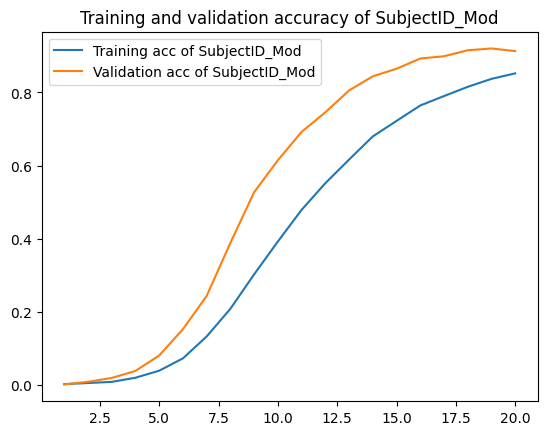

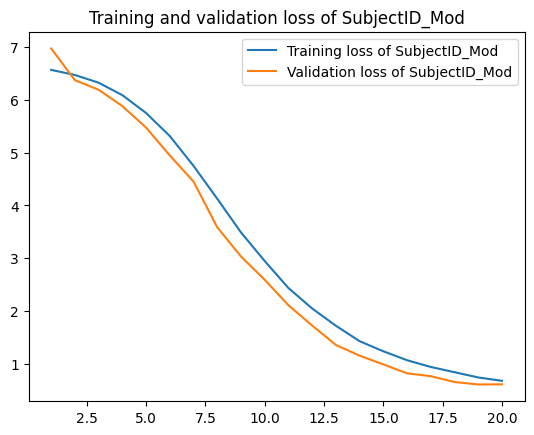

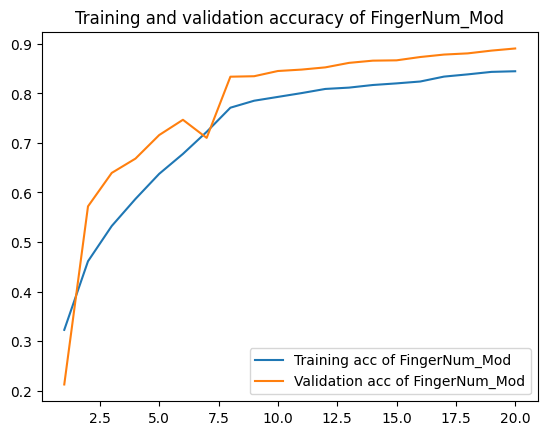

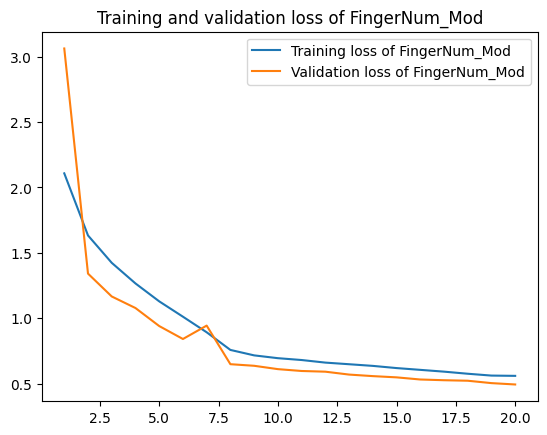

In [ ]:
# Origional method results
## DO NOT RUN!!

acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

Id recognition accuracy:  99.18333292007446 %
Finger recognition accuracy:  99.08333420753479 %


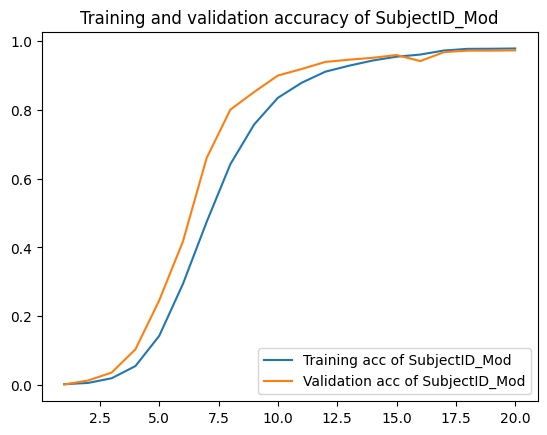

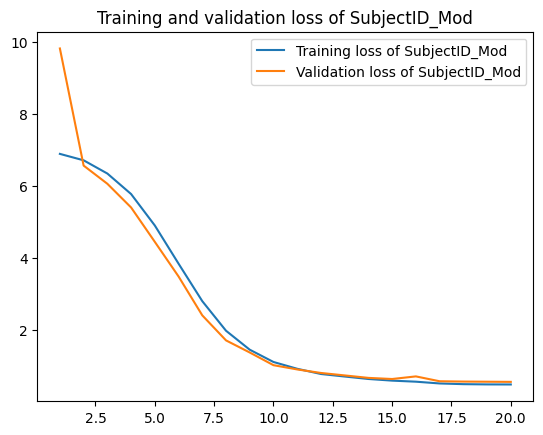

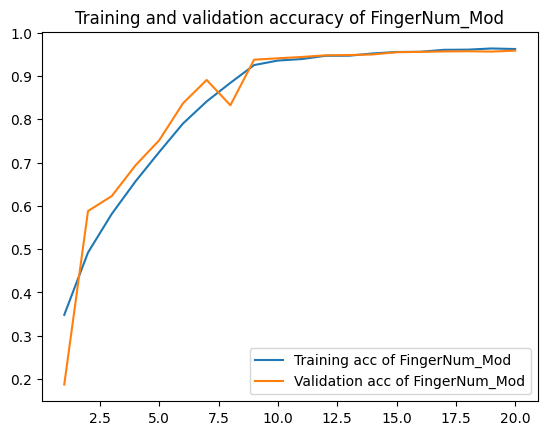

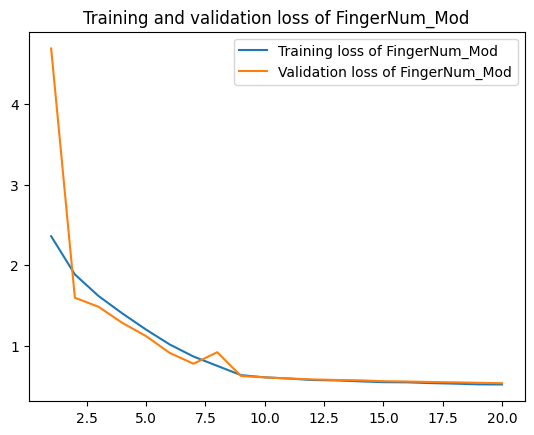

In [20]:
# EXPIREMENTAL RESULTS

acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

In [ ]:
# Visualize finger prediction with confusion matrix 
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
y_fingerNum_pred = model[1].predict(X_test)
# Convert predictions classes to one hot vectors 
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred, axis=1) 
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [ ]:
def show_fingername(fingernum):
    if fingernum>=5:
        fingername = "right "
        fingernum -= 5
    else: fingername = "left "
    if fingernum==0:
        fingername += "little"
    elif fingernum==1:
        fingername += "ring"
    elif fingernum==2:
        fingername += "middle"
    elif fingernum==3:
        fingername += "index"
    else: fingername += "thumb"
    return fingername

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred = model[0].predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_SubjectID_test[rand_fp_num])
fingerNum_pred = np.argmax(y_fingerNum_pred[rand_fp_num])
fingerNum_real = np.argmax(y_fingerNum_test[rand_fp_num])
if Id_pred==Id_real and fingerNum_pred==fingerNum_real:
    print("Infomation confirm! Fingerprint matches: person Id",Id_pred, show_fingername(fingerNum_pred))
else:
    print("Oops! Prediction is wrong!")